In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle) # if there's an "SavedModel file does not exist at:", delete that folder and rerun it

2023-02-22 23:02:31.228697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 23:02:35.245860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# scan data directories
import glob

nature_file_list = []
nature_file_list += glob.glob('../data/interim/AmbisonicSoundLibrary/nature/*')
nature_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, rural or natural/*')
nature_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_nature/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/non_urban/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/urban_0_25/*')

city_file_list = []
city_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, urban or manmade/*')
city_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_city/*')
# city_file_list += glob.glob('../data/interim/S2L_LULC/urban_26_100/*')

# these two directories have way too many files, which will biase the training toward the difference between these 2 them rather the category
NS_file_list = glob.glob('../data/interim/youtube/NatureSoundscapes/*')
SONYC_file_list = glob.glob('../data/interim/SONYC/**/*.pkl')

import random
random.seed(23)
n_files_minus = 1600
NS_file_list_sampled = random.sample(NS_file_list, len(NS_file_list)-n_files_minus)
SONYC_file_list_sampled = random.sample(SONYC_file_list, len(SONYC_file_list)-n_files_minus)

nature_file_list += NS_file_list_sampled
city_file_list += SONYC_file_list_sampled 

nature_source_list = ['nature_'+i.rsplit('/', 3)[1]+'/'+i.rsplit('/', 3)[2] for i in nature_file_list]
city_source_list = ['city_'+i.rsplit('/', -1)[3] for i in city_file_list]

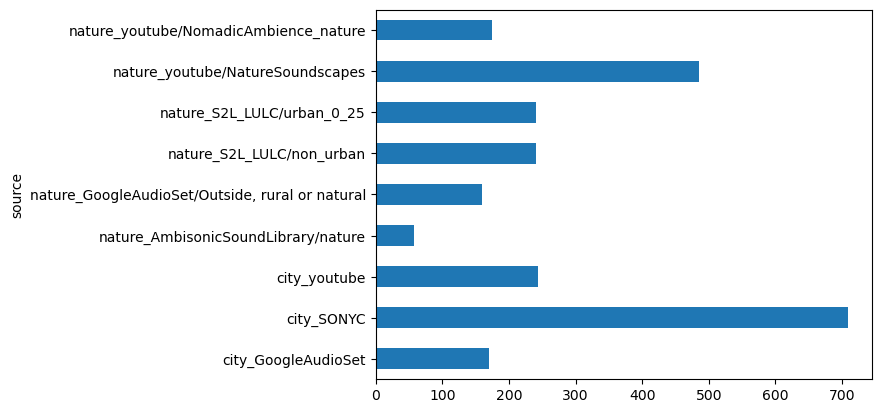

In [3]:
nature_df = pd.DataFrame({'file': nature_file_list, 'source': nature_source_list, 'category': 0})
city_df = pd.DataFrame({'file': city_file_list, 'source': city_source_list, 'category': 1})
df_all = pd.concat([nature_df, city_df], ignore_index=True)
source_count = df_all.groupby(['source'])['file'].count()
ax = source_count.plot.barh()
plt.show()

In [4]:
# extract the youtube ID of the file out and put it as 'file_group'
df_all['file_group'] = df_all['file'].apply(lambda st: st[st.find('/youtube/')+1:st.rfind("_")])

# for the rows that were not extracted from youtube, replace the 'file_group' by 'file', as they are all from different sources
df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file_group'] = df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file']
df_all

,file,source,category,file_group
0,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary/nature,0,../data/interim/AmbisonicSoundLibrary/nature/W...
1,../data/interim/AmbisonicSoundLibrary/nature/R...,nature_AmbisonicSoundLibrary/nature,0,../data/interim/AmbisonicSoundLibrary/nature/R...
2,../data/interim/AmbisonicSoundLibrary/nature/A...,nature_AmbisonicSoundLibrary/nature,0,../data/interim/AmbisonicSoundLibrary/nature/A...
3,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary/nature,0,../data/interim/AmbisonicSoundLibrary/nature/W...
4,../data/interim/AmbisonicSoundLibrary/nature/L...,nature_AmbisonicSoundLibrary/nature,0,../data/interim/AmbisonicSoundLibrary/nature/L...
...,...,...,...,...
2477,../data/interim/SONYC/audio-6/32_004222.pkl,city_SONYC,1,../data/interim/SONYC/audio-6/32_004222.pkl
2478,../data/interim/SONYC/audio-17/35_011631.pkl,city_SONYC,1,../data/interim/SONYC/audio-17/35_011631.pkl
2479,../data/interim/SONYC/audio-18/06_001066.pkl,city_SONYC,1,../data/interim/SONYC/audio-18/06_001066.pkl
2480,../data/interim/SONYC/audio-14/41_019620.pkl,city_SONYC,1,../data/interim/SONYC/audio-14/41_019620.pkl


In [5]:
from sklearn.model_selection import StratifiedGroupKFold

# Split the data into folds using StratifiedKFold
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=23)
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=df_all, y=df_all['source'], groups=df_all['file_group'])):
    # Assign the fold number to each row in the DataFrame
    df_all.loc[val_idx, 'fold'] = fold
    
df_all['fold'] = df_all['fold'].astype('int')
df_all = df_all.sample(frac=1, random_state=23).reset_index(drop=True) # need to shuffle the rows before deep learning
df_all

,file,source,category,file_group,fold
0,../data/interim/S2L_LULC/non_urban/s2lam112_21...,nature_S2L_LULC/non_urban,0,../data/interim/S2L_LULC/non_urban/s2lam112_21...,0
1,../data/interim/youtube/NomadicAmbience_city/-...,city_youtube,1,youtube/NomadicAmbience_city/-veiV1hHEbA,1
2,../data/interim/youtube/NomadicAmbience_nature...,nature_youtube/NomadicAmbience_nature,0,youtube/NomadicAmbience_nature/On_o9K0PBAs,1
3,../data/interim/youtube/NomadicAmbience_city/Y...,city_youtube,1,youtube/NomadicAmbience_city/YNAdzvW-ZTc,4
4,../data/interim/youtube/NomadicAmbience_city/7...,city_youtube,1,youtube/NomadicAmbience_city/7dfpryACUV4,7
...,...,...,...,...,...
2477,"../data/interim/GoogleAudioSet/Outside, urban ...",city_GoogleAudioSet,1,"../data/interim/GoogleAudioSet/Outside, urban ...",9
2478,../data/interim/SONYC/audio-10/41_008799.pkl,city_SONYC,1,../data/interim/SONYC/audio-10/41_008799.pkl,6
2479,../data/interim/youtube/NatureSoundscapes/fpPF...,nature_youtube/NatureSoundscapes,0,youtube/NatureSoundscapes/fpPF-uoLaCE,1
2480,../data/interim/S2L_LULC/urban_0_25/s2lam051_2...,nature_S2L_LULC/urban_0_25,0,../data/interim/S2L_LULC/urban_0_25/s2lam051_2...,6


In [6]:
# df_all.to_csv('../train_val_test_split_Feb21.csv')
df_all.to_csv('../train_val_test_sgkf_Feb22.csv')

# Convert data into TF format

In [7]:
filenames = df_all['file']
targets = df_all['category']
folds = df_all['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
def load_wav_pkl(filename, wav_label='y'):
    import pickle
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    wav = output[wav_label]

    # close the file
    file.close()
    return wav

wav_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'])) == 160000:
        wav_list.append(load_wav_pkl(row['file']))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'])
        print('short length: '+str(len(temp_wav)))
        wav_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_bg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'bg_y')) == 160000:
        wav_bg_list.append(load_wav_pkl(row['file'], 'bg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'bg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_bg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_fg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'fg_y')) == 160000:
        wav_fg_list.append(load_wav_pkl(row['file'], 'fg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'fg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_fg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

short length: 151683
short length: 159992
short length: 156480
short length: 146099
short length: 153357
short length: 159999
short length: 159880
short length: 148006
short length: 153242
short length: 159997
short length: 159880
short length: 159880
short length: 159993
short length: 159880
short length: 157848
short length: 151461


In [9]:
main_ds = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), df_all['category'], df_all['fold']))
main_ds_fg = tf.data.Dataset.from_tensor_slices((np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold']))
main_ds_bg = tf.data.Dataset.from_tensor_slices((np.stack(wav_bg_list, axis = 0), df_all['category'], df_all['fold']))

main_ds.element_spec

(TensorSpec(shape=(160000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [10]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    # run YAMNet to extract embedding from the wav data
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds_fg = main_ds_fg.map(extract_embedding).unbatch()
main_ds_bg = main_ds_bg.map(extract_embedding).unbatch()

main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [11]:
main_ds_all3 = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), np.stack(wav_bg_list, axis = 0), np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold']))
main_ds_all3.element_spec

(TensorSpec(shape=(160000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(160000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(160000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
# applies the embedding extraction model to a wav data
def extract_embedding_3(wav_data_raw, wav_data_bg, wav_data_fg, label, fold):
    # run YAMNet to extract embedding from the wav data
    scores, embeddings_raw, spectrogram = yamnet_model(wav_data_raw)
    scores, embeddings_bg, spectrogram = yamnet_model(wav_data_bg)
    scores, embeddings_fg, spectrogram = yamnet_model(wav_data_fg)
    num_embeddings_raw = tf.shape(embeddings_raw)[0]
    return (tf.concat([embeddings_raw, embeddings_bg, embeddings_fg],1),
            tf.repeat(label, num_embeddings_raw),
            tf.repeat(fold, num_embeddings_raw))

# extract embedding
main_ds_3 = main_ds_all3.map(extract_embedding_3).unbatch()

main_ds_3.element_spec

(TensorSpec(shape=(3072,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
## raw signal
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 8)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 8)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 9)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
## background sound
cached_ds_bg = main_ds_bg.cache()
train_ds_bg = cached_ds_bg.filter(lambda embedding, label, fold: fold < 8)
val_ds_bg = cached_ds_bg.filter(lambda embedding, label, fold: fold == 8)
test_ds_bg = cached_ds_bg.filter(lambda embedding, label, fold: fold == 9)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds_bg = train_ds_bg.map(remove_fold_column)
val_ds_bg = val_ds_bg.map(remove_fold_column)
test_ds_bg = test_ds_bg.map(remove_fold_column)

train_ds_bg = train_ds_bg.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_bg = val_ds_bg.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_bg = test_ds_bg.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
## foreground sound
cached_ds_fg = main_ds_fg.cache()
train_ds_fg = cached_ds_fg.filter(lambda embedding, label, fold: fold < 8)
val_ds_fg = cached_ds_fg.filter(lambda embedding, label, fold: fold == 8)
test_ds_fg = cached_ds_fg.filter(lambda embedding, label, fold: fold == 9)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds_fg = train_ds_fg.map(remove_fold_column)
val_ds_fg = val_ds_fg.map(remove_fold_column)
test_ds_fg = test_ds_fg.map(remove_fold_column)

train_ds_fg = train_ds_fg.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_fg = val_ds_fg.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_fg = test_ds_fg.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
## all 3 signals
cached_ds_3 = main_ds_3.cache()
train_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold < 8)
val_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold == 8)
test_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold == 9)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds_3 = train_ds_3.map(remove_fold_column)
val_ds_3 = val_ds_3.map(remove_fold_column)
test_ds_3 = test_ds_3.map(remove_fold_column)

train_ds_3 = train_ds_3.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_3 = val_ds_3.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_3 = test_ds_3.cache().batch(32).prefetch(tf.data.AUTOTUNE)

# Model of raw signal

In [17]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


raw_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='raw_model')

raw_model.summary()

Model: "raw_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [18]:
raw_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

# callback will be used in the other models below too
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [19]:
history = raw_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 175s 136ms/step - loss: 0.2766 - accuracy: 0.8868 - val_loss: 0.2732 - val_accuracy: 0.8928
Epoch 2/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.2348 - accuracy: 0.9041 - val_loss: 0.3273 - val_accuracy: 0.8649
Epoch 3/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.2092 - accuracy: 0.9145 - val_loss: 0.2936 - val_accuracy: 0.8796
Epoch 4/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1898 - accuracy: 0.9234 - val_loss: 0.3152 - val_accuracy: 0.8881
Epoch 5/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1756 - accuracy: 0.9291 - val_loss: 0.3126 - val_accuracy: 0.8874
Epoch 6/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1608 - accuracy: 0.9357 - val_loss: 0.3047 - val_accuracy: 0.9002
Epoch 7/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1480 - accuracy: 0.9423 - val_loss: 0.3228 - val_accur

In [20]:
# this is the accuracy per YAMNet sample, not the accuracy per audio file
loss, accuracy = raw_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 2s 6ms/step - loss: 0.7342 - accuracy: 0.8559
Loss:  0.7341769337654114
Accuracy:  0.8559288382530212


In [21]:
def acc_by_audio(model, test_ds, y_true):
    n_sample_per_audio = 20
    y_pred = model.predict(test_ds)
    y_reshaped = y_pred.reshape(-1, n_sample_per_audio, 2) # reshape to audio*sample*binary_prediction
    y_pred_by_row = y_reshaped.mean(axis=1).argmax(axis=1)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred_by_row), y_pred_by_row


In [22]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(raw_model, test_ds, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 1ms/step
0.8853754940711462


In [23]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_87632/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


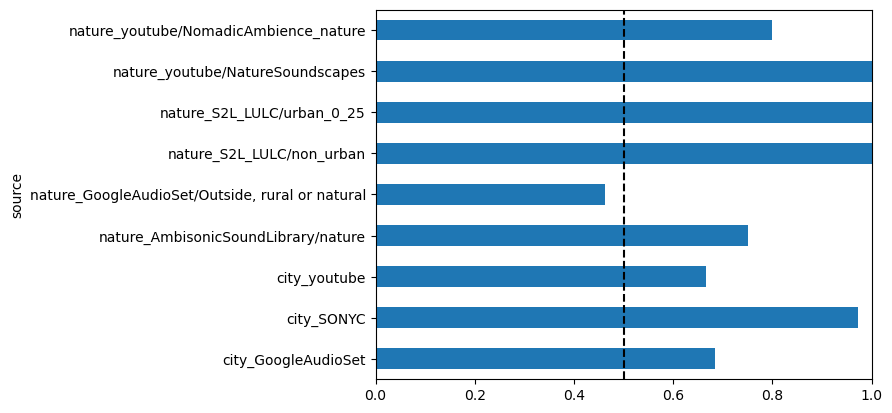

In [24]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of background signal

In [25]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


bg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='bg_model')

bg_model.summary()

Model: "bg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [26]:
bg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

history = bg_model.fit(train_ds_bg,
                       epochs=20,
                       validation_data=val_ds_bg,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 180s 141ms/step - loss: 0.2826 - accuracy: 0.8842 - val_loss: 0.2602 - val_accuracy: 0.8962
Epoch 2/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.2335 - accuracy: 0.9039 - val_loss: 0.2676 - val_accuracy: 0.8902
Epoch 3/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.2084 - accuracy: 0.9151 - val_loss: 0.2912 - val_accuracy: 0.8811
Epoch 4/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.1912 - accuracy: 0.9232 - val_loss: 0.2911 - val_accuracy: 0.8855
Epoch 5/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.1738 - accuracy: 0.9297 - val_loss: 0.3045 - val_accuracy: 0.8849
Epoch 6/20
1247/1247 [==============================] - 4s 3ms/step - loss: 0.1603 - accuracy: 0.9367 - val_loss: 0.3129 - val_accuracy: 0.8855
Epoch 7/20
1247/1247 [==============================] - 5s 4ms/step - loss: 0.1491 - accuracy: 0.9419 - val_loss: 0.3462 - val_accur

In [27]:
loss, accuracy = bg_model.evaluate(test_ds_bg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 3s 8ms/step - loss: 0.7925 - accuracy: 0.8498
Loss:  0.7924672365188599
Accuracy:  0.8498023748397827


In [28]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(bg_model, test_ds_bg, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 3ms/step
0.8774703557312253


In [29]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_87632/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


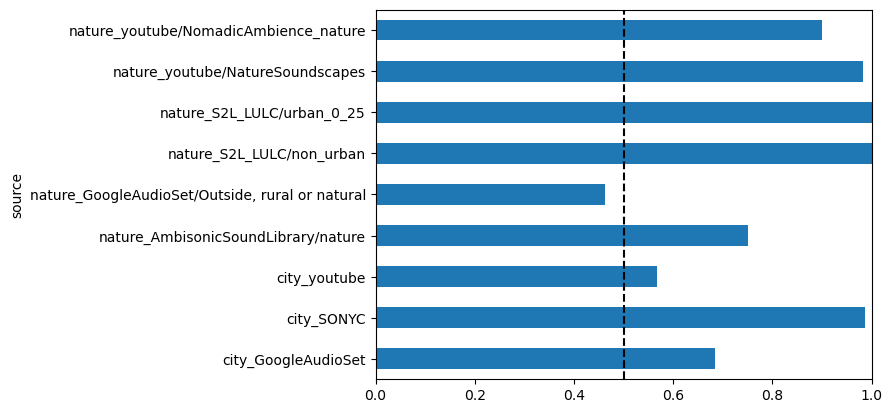

In [30]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of foreground signal

In [31]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


fg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='fg_model')

fg_model.summary()

Model: "fg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [32]:
fg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

history = fg_model.fit(train_ds_fg,
                       epochs=20,
                       validation_data=val_ds_fg,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 180s 139ms/step - loss: 0.5429 - accuracy: 0.7318 - val_loss: 0.5631 - val_accuracy: 0.7066
Epoch 2/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.4983 - accuracy: 0.7560 - val_loss: 0.5507 - val_accuracy: 0.7200
Epoch 3/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.4830 - accuracy: 0.7650 - val_loss: 0.5002 - val_accuracy: 0.7426
Epoch 4/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.4690 - accuracy: 0.7742 - val_loss: 0.4972 - val_accuracy: 0.7464
Epoch 5/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.4550 - accuracy: 0.7831 - val_loss: 0.5158 - val_accuracy: 0.7370
Epoch 6/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.4466 - accuracy: 0.7880 - val_loss: 0.4938 - val_accuracy: 0.7555
Epoch 7/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.4355 - accuracy: 0.7932 - val_loss: 0.5078 - val_accur

In [33]:
loss, accuracy = fg_model.evaluate(test_ds_fg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 2s 5ms/step - loss: 0.7270 - accuracy: 0.7014
Loss:  0.72700434923172
Accuracy:  0.7013834118843079


In [34]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(fg_model, test_ds_fg, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 784us/step
0.8181818181818182


In [35]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_87632/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


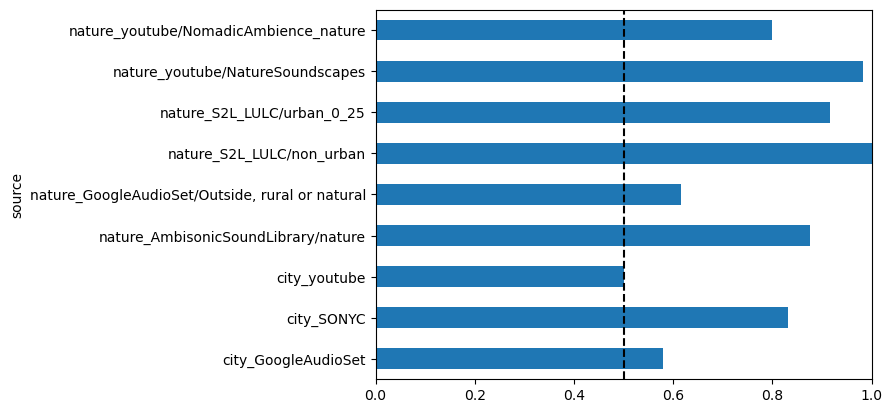

In [36]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of 3 signals

In [37]:
# my_classes = ['city', 'nature']
# tf.keras.backend.clear_session()
# tf.random.seta_seed(23)

# all3_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(3072), dtype=tf.float32,
#                           name='input_embedding'),
#     tf.keras.layers.Dense(1024, activation='relu'),
# #     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(len(my_classes))
# ], name='all3_model')

# all3_model.summary()

In [38]:
# all3_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                     optimizer="adam",
#                     metrics=['accuracy'])

# # callback will be used in the other models below too
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=3,
#                                             restore_best_weights=True)


# history = all3_model.fit(train_ds_3,
#                        epochs=20,
#                        validation_data=val_ds_3,
#                        callbacks=callback)

In [39]:
# loss, accuracy = all3_model.evaluate(test_ds_3)

# print("Loss: ", loss)
# print("Accuracy: ", accuracy)

In [40]:
# test_df = df_all[df_all['fold']==9]
# acc = acc_by_audio(all3_model, test_ds_3, y_true = test_df['category'])
# print(acc)